In [14]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

np.random.seed(123)

/home/harrison/miniforge3/envs/proteus/lib/python3.12/site-packages/arviz/__init__.py:50: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


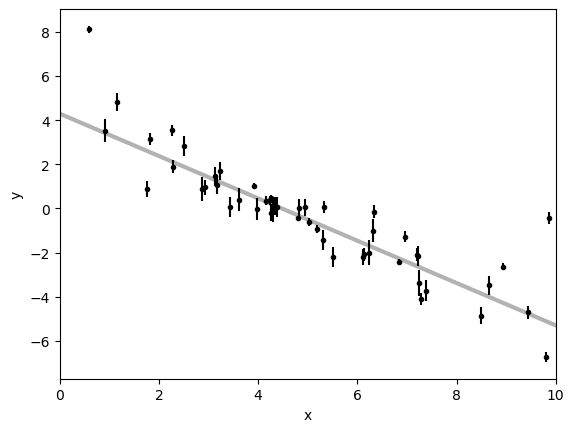

In [10]:
# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true             # The model without noise.
y += np.abs(f_true * y) * np.random.randn(N) # Add noise proportional to the model.
y += yerr * np.random.randn(N) 

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

There isn’t a generalization of least squares that supports a model like the one that we know to be true. Instead, we need to write down the likelihood function and numerically optimize it. In mathematical notation, the correct likelihood function is:

In [2]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


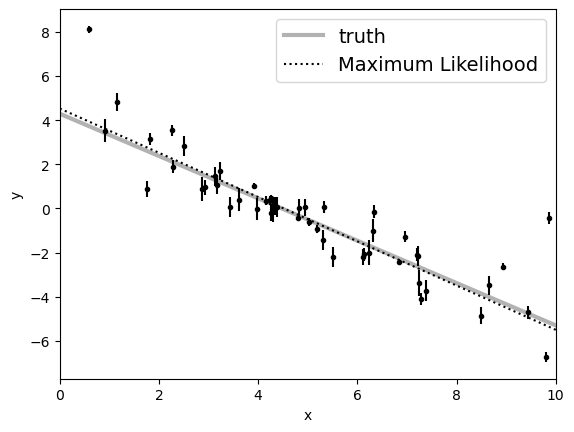

In [5]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
# plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="Maximum Likelihood")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");


how do we estimate the uncertainties on m and b? What’s more, we probably don’t really care too much about the value of f but it seems worthwhile to propagate any uncertainties about its value to our final estimates of m and b. This is where MCMC comes in.

we’ll use uniform (so-called “uninformative”) priors on m,b and the logarithm of f. 
For example, we’ll use the following conservative prior on m:

In [6]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

combining this with the definition of log_likelihood from above, the full log-probability function is:

In [8]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

it’s easy to sample this distribution using emcee. We’ll start by initializing the walkers in a tiny Gaussian ball around the maximum likelihood result

In [11]:

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:01<00:00, 2876.48it/s]


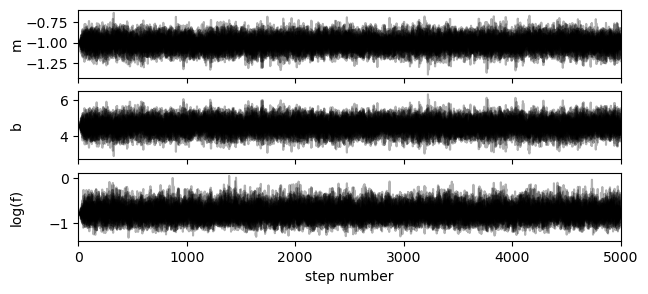

In [13]:
fig, axes = plt.subplots(3, figsize=(7, 3), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

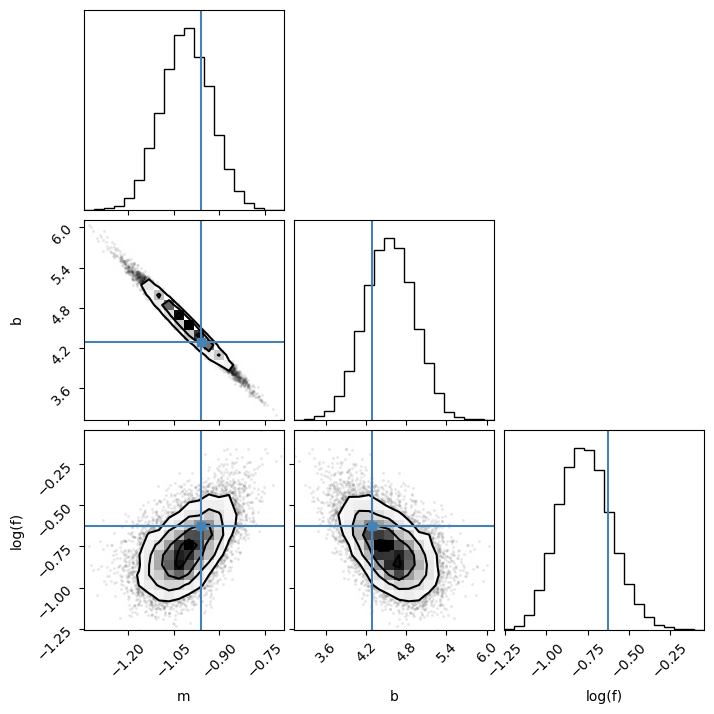

In [16]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

Another diagnostic plot is the projection of your results into the space of the observed data. To do this, you can choose a few (say 100 in this case) samples from the chain and plot them on top of the data points:

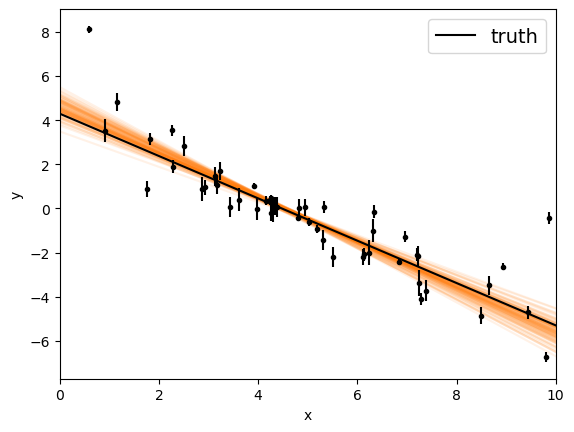

In [17]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

This leaves us with one question: which numbers should go in the abstract? There are a few different options for this but my favorite is to quote the uncertainties based on the 16th, 50th, and 84th percentiles of the samples in the marginalized distributions. To compute these numbers for this example, you would run:

In [24]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{labels[i]:7s} = {mcmc[1]:+.3f} _-{q[0]:.3f} ^+{q[1]:.3f}")

m       = -1.009 _-0.081 ^+0.079
b       = +4.553 _-0.368 ^+0.368
log(f)  = -0.768 _-0.152 ^+0.163


In [25]:
print(m_true, b_true, f_true)

-0.9594 4.294 0.534
